In [1]:
import random

# for data, model, training
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import basics

# Set the seed value for experiment reproducibility.
seed = 42
random.seed(42)
tf.random.set_random_seed(seed)
np.random.seed(seed)

In [2]:
filenames = basics.get_and_shuffle_filenames("./recordings")

print(filenames[:5])

['./recordings/2_jackson_13.wav', './recordings/6_george_34.wav', './recordings/7_george_5.wav', './recordings/1_yweweler_21.wav', './recordings/2_george_42.wav']


In [3]:
X_unfiltered = [(file_path, basics.decode_audio(file_path)) for file_path in filenames]

# to remove outliers 
max_length = basics.get_max_length(X_unfiltered)
print(max_length)

5632


In [14]:
X_full = [] # padded X values 0-7
y_full = []

numbers = [0] * 8

for file_path, audio in X_unfiltered:
    x_val = audio
    y_val = basics.get_label(file_path)
    signal_length = audio.shape[0]
    
    if y_val > 7:
        continue
    if signal_length > max_length:
        numbers[y_val] += 1
        continue
        
    x_val = np.pad(
        x_val, (0, max_length - signal_length), 
        'constant', constant_values=(0, 0))

    X_full.append(x_val)
    y_full.append(y_val)

X_full = np.array(X_full)
y_full = np.array(y_full)

print(X_full.shape)

num_samples, sample_w = X_full.shape
print(num_samples)
print(sample_w)

print(y_full[:10])

(2312, 5632)
2312
5632
[2 6 7 1 2 6 6 4 3 2]


In [15]:
# dropped outliers
df = pd.DataFrame.from_dict({"quantities": numbers})
print(df)
print(sum(numbers))

   quantities
0          12
1           9
2           7
3           9
4           3
5           8
6          29
7          11
88


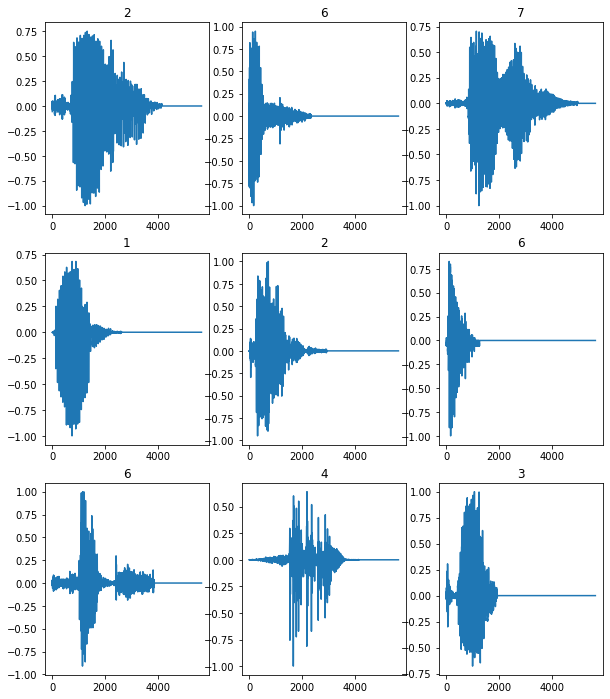

In [16]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(list(zip(X_full, y_full))[:n]):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio)
#     ax.set_yticks(np.arange(-1,1.5,0.5))
    ax.set_title(label)

plt.show()

In [17]:
tenth = int(num_samples * 0.1)
eightyth = tenth * 8

X_train = X_full[:eightyth]
y_train = y_full[:eightyth]

X_val = X_full[eightyth: eightyth + tenth]
y_val = y_full[eightyth: eightyth + tenth]

X_test = X_full[eightyth + tenth:]
y_test = y_full[eightyth + tenth:]

print('Training set size', len(X_train))
print('Validation set size', len(X_val))
print('Test set size', len(X_test))

Training set size 1848
Validation set size 231
Test set size 233


In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1000, activation="softmax", input_shape=(sample_w,)))
# model.add(tf.keras.layers.Dense(100, activation="softmax"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.build()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              5633000   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
Total params: 5,643,010
Trainable params: 5,643,010
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_val, y_val))

Train on 1848 samples, validate on 231 samples
Epoch 1/30
1848/1848 [==============================] - 1s 570us/sample - loss: 2.2885 - acc: 0.1326 - val_loss: 2.2746 - val_acc: 0.1429
Epoch 2/30
1848/1848 [==============================] - 1s 422us/sample - loss: 2.2571 - acc: 0.2808 - val_loss: 2.2509 - val_acc: 0.1169
Epoch 3/30
1848/1848 [==============================] - 1s 433us/sample - loss: 2.2215 - acc: 0.3647 - val_loss: 2.2241 - val_acc: 0.1515
Epoch 4/30
1848/1848 [==============================] - 1s 440us/sample - loss: 2.1717 - acc: 0.4778 - val_loss: 2.1979 - val_acc: 0.1775
Epoch 5/30
1848/1848 [==============================] - 1s 446us/sample - loss: 2.1096 - acc: 0.5411 - val_loss: 2.1745 - val_acc: 0.1991
Epoch 6/30
1848/1848 [==============================] - 1s 454us/sample - loss: 2.0388 - acc: 0.6526 - val_loss: 2.1511 - val_acc: 0.2121
Epoch 7/30
1848/1848 [==============================] - 1s 468us/sample - loss: 1.9636 - acc: 0.7229 - val_loss: 2.1336 - val

In [22]:
model.evaluate(X_test, y_test)

233/233 [==============================] - 0s 204us/sample - loss: 2.0039 - acc: 0.2575


[2.003935991438673, 0.25751072]

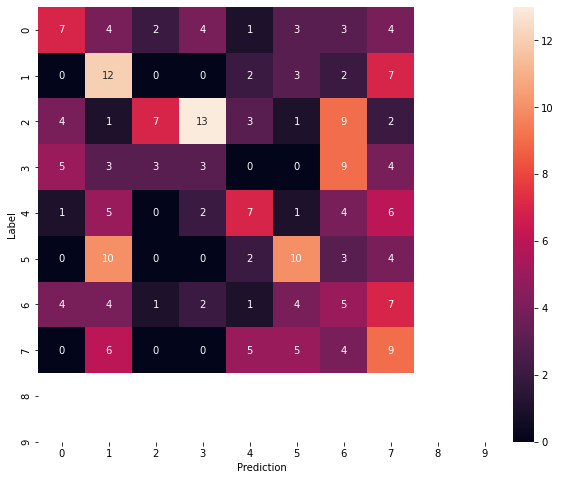

In [24]:
y_pred = np.argmax(model.predict(X_test), axis=1)

all_labels = list(range(10))

confusion_mtx = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [57]:
# model.save("model_v1.h5")